In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..','..','..'))
from ursse.hydra_harp_file_reader import HydraHarpFile
from ursse.LED_tests.data_analyzis import calc_Fano, get_time_window_hist, calc_Fano_from_counts_per_time_window
import numpy as np
import pandas as pd
import seaborn as sns
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 3.75]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import ursse.path_assistant as pa
shift = pa.PathAssistant('shift_02_28_2020')
from config_ursse import get_from_config
iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
iota_period_au = iota_period_sec/dt_sec
import ursse_cpp.sync_motion_sim as sm

In [2]:
df, n_revolutions = read_event_delays(shift.get_time_stamp_file_path('1el_002.ptu'))
t_delays = df.delay

In [3]:
gate = (61000, 66000)
dt=0.005 # sec

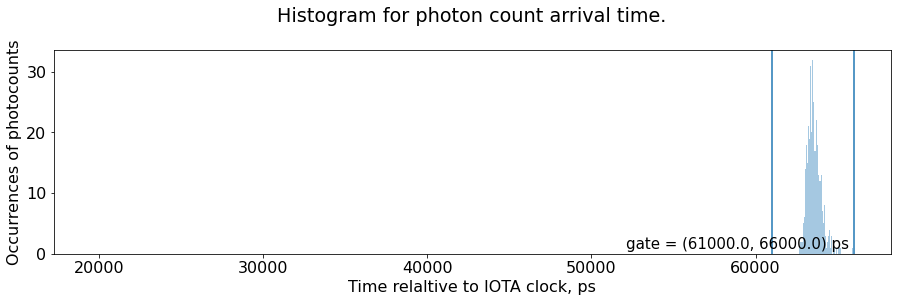

In [4]:
n = 500
i = 200
plot_arrival_time_hist(t_delays[i*n:(i+1)*n], gate=gate, bins=1000, yscale='linear')

In [5]:
from ursse.time_structure import get_bucket_gates, get_rate_in_gate_Hz,\
    reduce_df_to_one_gate, divide_df_into_time_bins, get_properties_in_time_bins
four_gates = get_bucket_gates(gate)
df0 = reduce_df_to_one_gate(df, gate).reset_index(drop=True)

In [6]:
delay_mean = df0['delay'].mean()
df0['delay'] = (df0['delay']-delay_mean)/1000

In [7]:
# import plotly.express as px
# fig = px.scatter(x=df0.loc[:1000, 'revolution'], y=df0.loc[:1000, 'delay'])
# fig.data[0].update(mode='markers+lines')
# fig.show()

In [8]:
t0=2372
first_fit_nper = 30
df0_first_fit = df0[df0['revolution']<t0*first_fit_nper]
from scipy.optimize import curve_fit
def f(t, a0, A, B, T):
    return a0 + A*np.cos(2*np.pi/T*t)+B*np.sin(2*np.pi/T*t)
x = df0_first_fit['revolution'].values
y = df0_first_fit['delay'].values
p0 = (np.mean(y), np.std(y), np.std(y), t0)
popt, pcov = curve_fit(f, x, y, p0=p0)
a0, a, b, T0 = popt
perr = np.sqrt(np.diag(pcov))
x_fit = np.linspace(x[0],x[-1],10000)
#x_fit_sec = x_fit*iota_period_sec
y_fit = f(x_fit, a0, a, b, T0)

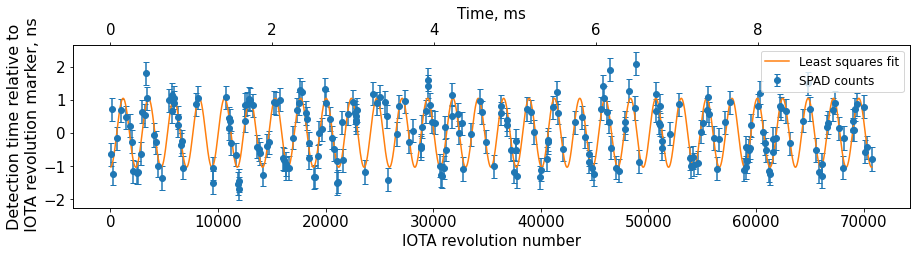

In [9]:
plt.rcParams.update({'font.size': 15,
                     'legend.fontsize':22,
                     'errorbar.capsize': 3,
                     'figure.figsize':(15,3)})
fig, ax = plt.subplots()
ax.errorbar(x, y, label='SPAD counts', yerr=0.35, marker='o', linestyle='None')
ax.plot(x_fit, y_fit, label='Least squares fit')
ax.set_ylabel('Detection time relative to\n IOTA revolution marker, ns', fontsize=16)
ax.set_xlabel('IOTA revolution number')
ax1 = ax.twiny()
ax1.set_xlim(1000*iota_period_sec*np.asarray(ax.get_xlim()))
ax1.set_xlabel('Time, ms')
#ax.set_xlim(0,0.0025)
ax.legend(loc=1, fontsize=12)

In [10]:
T0

2357.595282461189

In [11]:
# df0.loc[:,["revolution", "delay"]].to_csv("revolution_delay_60sec.csv",
#                                           index=None)

In [12]:
fitper = 20
fitrange = T0*fitper
overlapper = 3
overlaprange = T0*overlapper
starts = df0.groupby(((df0['revolution'].values)//(fitrange-overlaprange)).astype(int))\
    .apply(lambda v: v.index.values[0]).values
ends = df0.groupby(((df0['revolution'].values-overlaprange)//(fitrange-overlaprange)).astype(int))\
    .apply(lambda v: v.index.values[-1]).values[1:]
nintervals = min(len(starts), len(ends))
starts = starts[:nintervals]
ends = ends[:nintervals]

Text(0.5, 0, 'Time (ms)')

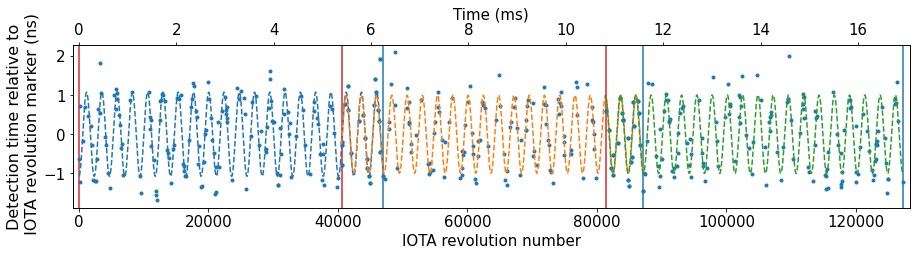

In [13]:
fig, ax = plt.subplots(figsize=[15,3])
n1,n2 = 0,3
for s,e in zip(starts[n1:n2],ends[n1:n2]):
    ax.axvline(df0.loc[s,'revolution'], color='tab:red')
    ax.axvline(df0.loc[e,'revolution'], color='tab:blue')
    v = df0.loc[s:e,:]
    x = v['revolution'].values
    y = v['delay'].values
    A = np.vstack([np.cos(2*np.pi/T0*x),np.sin(2*np.pi/T0*x)]).T
    a,b = np.linalg.lstsq(A, y, rcond=None)[0]
    ax.plot(x, y, '.', color='tab:blue')
    x_fit = np.linspace(x[0],x[-1],1000)
    y_fit = f(x_fit, 0, a, b, T0)
    ax.plot(x_fit, y_fit,'--')
ax.set_xlim(df0.loc[starts[n1],'revolution']-1000,
            df0.loc[ends[n2-1],'revolution']+1000)
ax.set_ylabel('Detection time relative to\n IOTA revolution marker (ns)', fontsize=16)
ax.set_xlabel('IOTA revolution number')
ax1 = ax.twiny()
ax1.set_xlim(1000*iota_period_sec*np.asarray(ax.get_xlim()))
ax1.set_xlabel('Time (ms)')

In [14]:
alist, blist = [],[]
for s,e in zip(starts, ends):
    v = df0.loc[s:e,:]
    x = v['revolution'].values
    y = v['delay'].values
    A = np.vstack([np.cos(2*np.pi/T0*x),np.sin(2*np.pi/T0*x)]).T
    a,b = np.linalg.lstsq(A, y, rcond=None)[0]
    alist.append(a)
    blist.append(b)

In [15]:
fits_df = pd.DataFrame({'start_idx': starts, 'end_idx': ends,
                        'A': alist, 'B': blist})
fits_df_len = len(fits_df.index)
fits_df['start_revolution'] = df0.loc[starts, 'revolution']\
    .reset_index(drop=True)
fits_df['end_revolution'] = df0.loc[ends, 'revolution']\
    .reset_index(drop=True)
fits_df['next_start_revolution'] = fits_df['start_revolution']\
    .shift(-1).values.astype(int)
fits_df['previous_end_revolution'] = fits_df['end_revolution']\
    .shift(1).values.astype(int)
fits_df.loc[fits_df_len-1,'next_start_revolution'] = \
    fits_df.loc[fits_df_len-1,'end_revolution']
fits_df.loc[0,'previous_end_revolution'] = \
    fits_df.loc[0, 'start_revolution']
fits_df['next_A'] = fits_df['A'].shift(-1)
fits_df['next_B'] = fits_df['B'].shift(-1)

fits_df.head()

,start_idx,end_idx,A,B,start_revolution,end_revolution,next_start_revolution,previous_end_revolution,next_A,next_B
0,0,167,-1.073324,-0.039884,51,47002,40565,51,-0.994861,0.024116
1,146,293,-0.994861,0.024116,40565,87146,81368,47002,-0.990569,0.145417
2,273,431,-0.990569,0.145417,81368,127295,120265,87146,-1.081387,0.134317
3,405,574,-1.081387,0.134317,120265,167183,160442,127295,-1.236659,0.175761
4,551,733,-1.236659,0.175761,160442,207363,200481,167183,-1.158118,0.174938


In [16]:
nper_step = 10
def get_one_fit(row):
    revs = np.arange(row['previous_end_revolution'],
                     row['end_revolution'],
                     nper_step)
    def interpAB(val1, val2):
        return np.interp(
            revs,
            [
                row['previous_end_revolution'],
                row['next_start_revolution'],
                row['end_revolution']
            ],
            [val1, val1, val2]
            )
    avals = interpAB(row['A'], row['next_A'])
    bvals = interpAB(row['B'], row['next_B'])
    dels = f(revs, 0, avals, bvals, T0)
    return pd.DataFrame({'revolution': revs.astype(int), 'delay': dels})

In [17]:
res = fits_df.apply(get_one_fit, axis=1)
res = pd.concat(res.to_list(), ignore_index=True, sort=False)

In [18]:
import scipy.interpolate
new_revs = np.arange(0,res['revolution'].max(),nper_step)
new_dels = scipy.interpolate.interp1d(res['revolution'], res['delay'],
                          bounds_error=False,
                          fill_value="extrapolate")(
    new_revs)
res = pd.DataFrame({'revolution': new_revs, 'delay': new_dels})

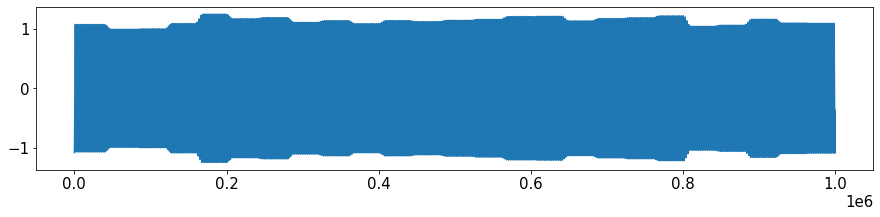

In [19]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(res.loc[:100000,'revolution'],res.loc[:100000,'delay'])

In [20]:
trigger_level = 0
ts = res['delay'].values
above_tl = np.where(ts > trigger_level, 1, 0)
dif = np.diff(above_tl)
pos_edges = np.where(dif > 0, 1, 0)
ts_dif = np.diff(ts)
timeline = np.arange(len(ts) - 1)
interpolated_time = timeline - (ts[1:] - trigger_level)\
                    / np.where(ts_dif != 0,ts_dif,10)
trig_times = nper_step*interpolated_time[pos_edges > 0] + 1

In [21]:
trig_times

array([5.94335482e+02, 2.95193076e+03, 5.30952585e+03, ...,
       4.50117517e+08, 4.50119874e+08, 4.50122232e+08])

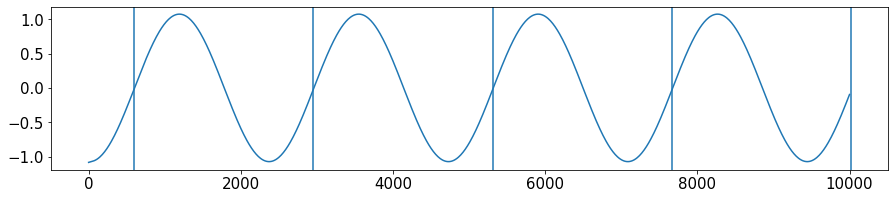

In [22]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(res.loc[:1000,'revolution'],res.loc[:1000,'delay'])
for t in trig_times[:5]:
    plt.axvline(t)

In [23]:
rev_numbers = np.arange(len(trig_times))
A = np.vstack([rev_numbers,np.ones(shape=rev_numbers.shape)]).T
Tfit, b = np.linalg.lstsq(A, trig_times, rcond=None)[0]
Tfit, b

(2353.3691474101274, -1402.250453901025)

In [24]:
from scipy import stats
stats.linregress(rev_numbers, trig_times)

LinregressResult(slope=2353.3691474101256, intercept=-1402.2504538595676, rvalue=0.9999999822634374, pvalue=0.0, stderr=0.001013469495091794)

In [25]:
phase_df = pd.DataFrame({"time_sec": rev_numbers*Tfit*iota_period_sec,
                         "phase_rad": 2*np.pi*(trig_times-Tfit*rev_numbers)/T0
                        })

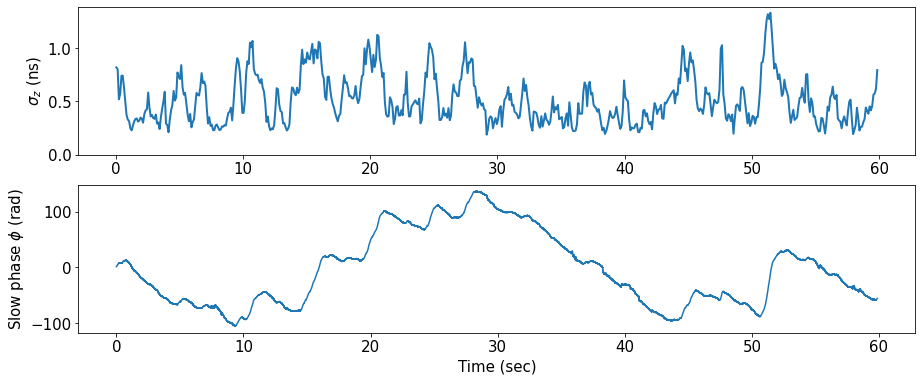

In [26]:
plt.rcParams.update({'font.size': 15,
                     'legend.fontsize':22})
fig, ax = plt.subplots(2,figsize=(15,6))
dt=0.1 # sec
spad_tts = 0.35 #ns
revolutions_per_dt = dt/iota_period_sec
df0['index_of_dt_bin'] = (df0.revolution/revolutions_per_dt).astype(int)
df0['time_sec'] = df0['index_of_dt_bin']*dt+dt/2
rms_delay_df = pd.DataFrame({
    'time_sec': df0.groupby('index_of_dt_bin')['index_of_dt_bin']\
                .mean()*dt+dt/2,
    'rms_delay': np.sqrt(df0.groupby('index_of_dt_bin').delay.std()**2-spad_tts**2)
}).reset_index(drop=True)
plt.rcParams.update({'font.size': 17,
                     'legend.fontsize':22})
ax[0].plot(rms_delay_df['time_sec'],
        rms_delay_df['rms_delay'],
        linewidth=2)
#ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('$\sigma_z$ (ns)')
ax[0].set_ylim(0, ax[0].get_ylim()[1])
ax[1].plot(phase_df['time_sec'], phase_df['phase_rad'])
ax[1].set_ylabel(r"Slow phase $\phi$ (rad)")
ax[1].set_xlabel("Time (sec)")
fig.show()

[similar experiment from Novosibirsk](https://www.researchgate.net/publication/228393768_Longitudinal_Motion_in_Storage_Rings_and_Quantum_Excitation)

shown time = 5.0 sec


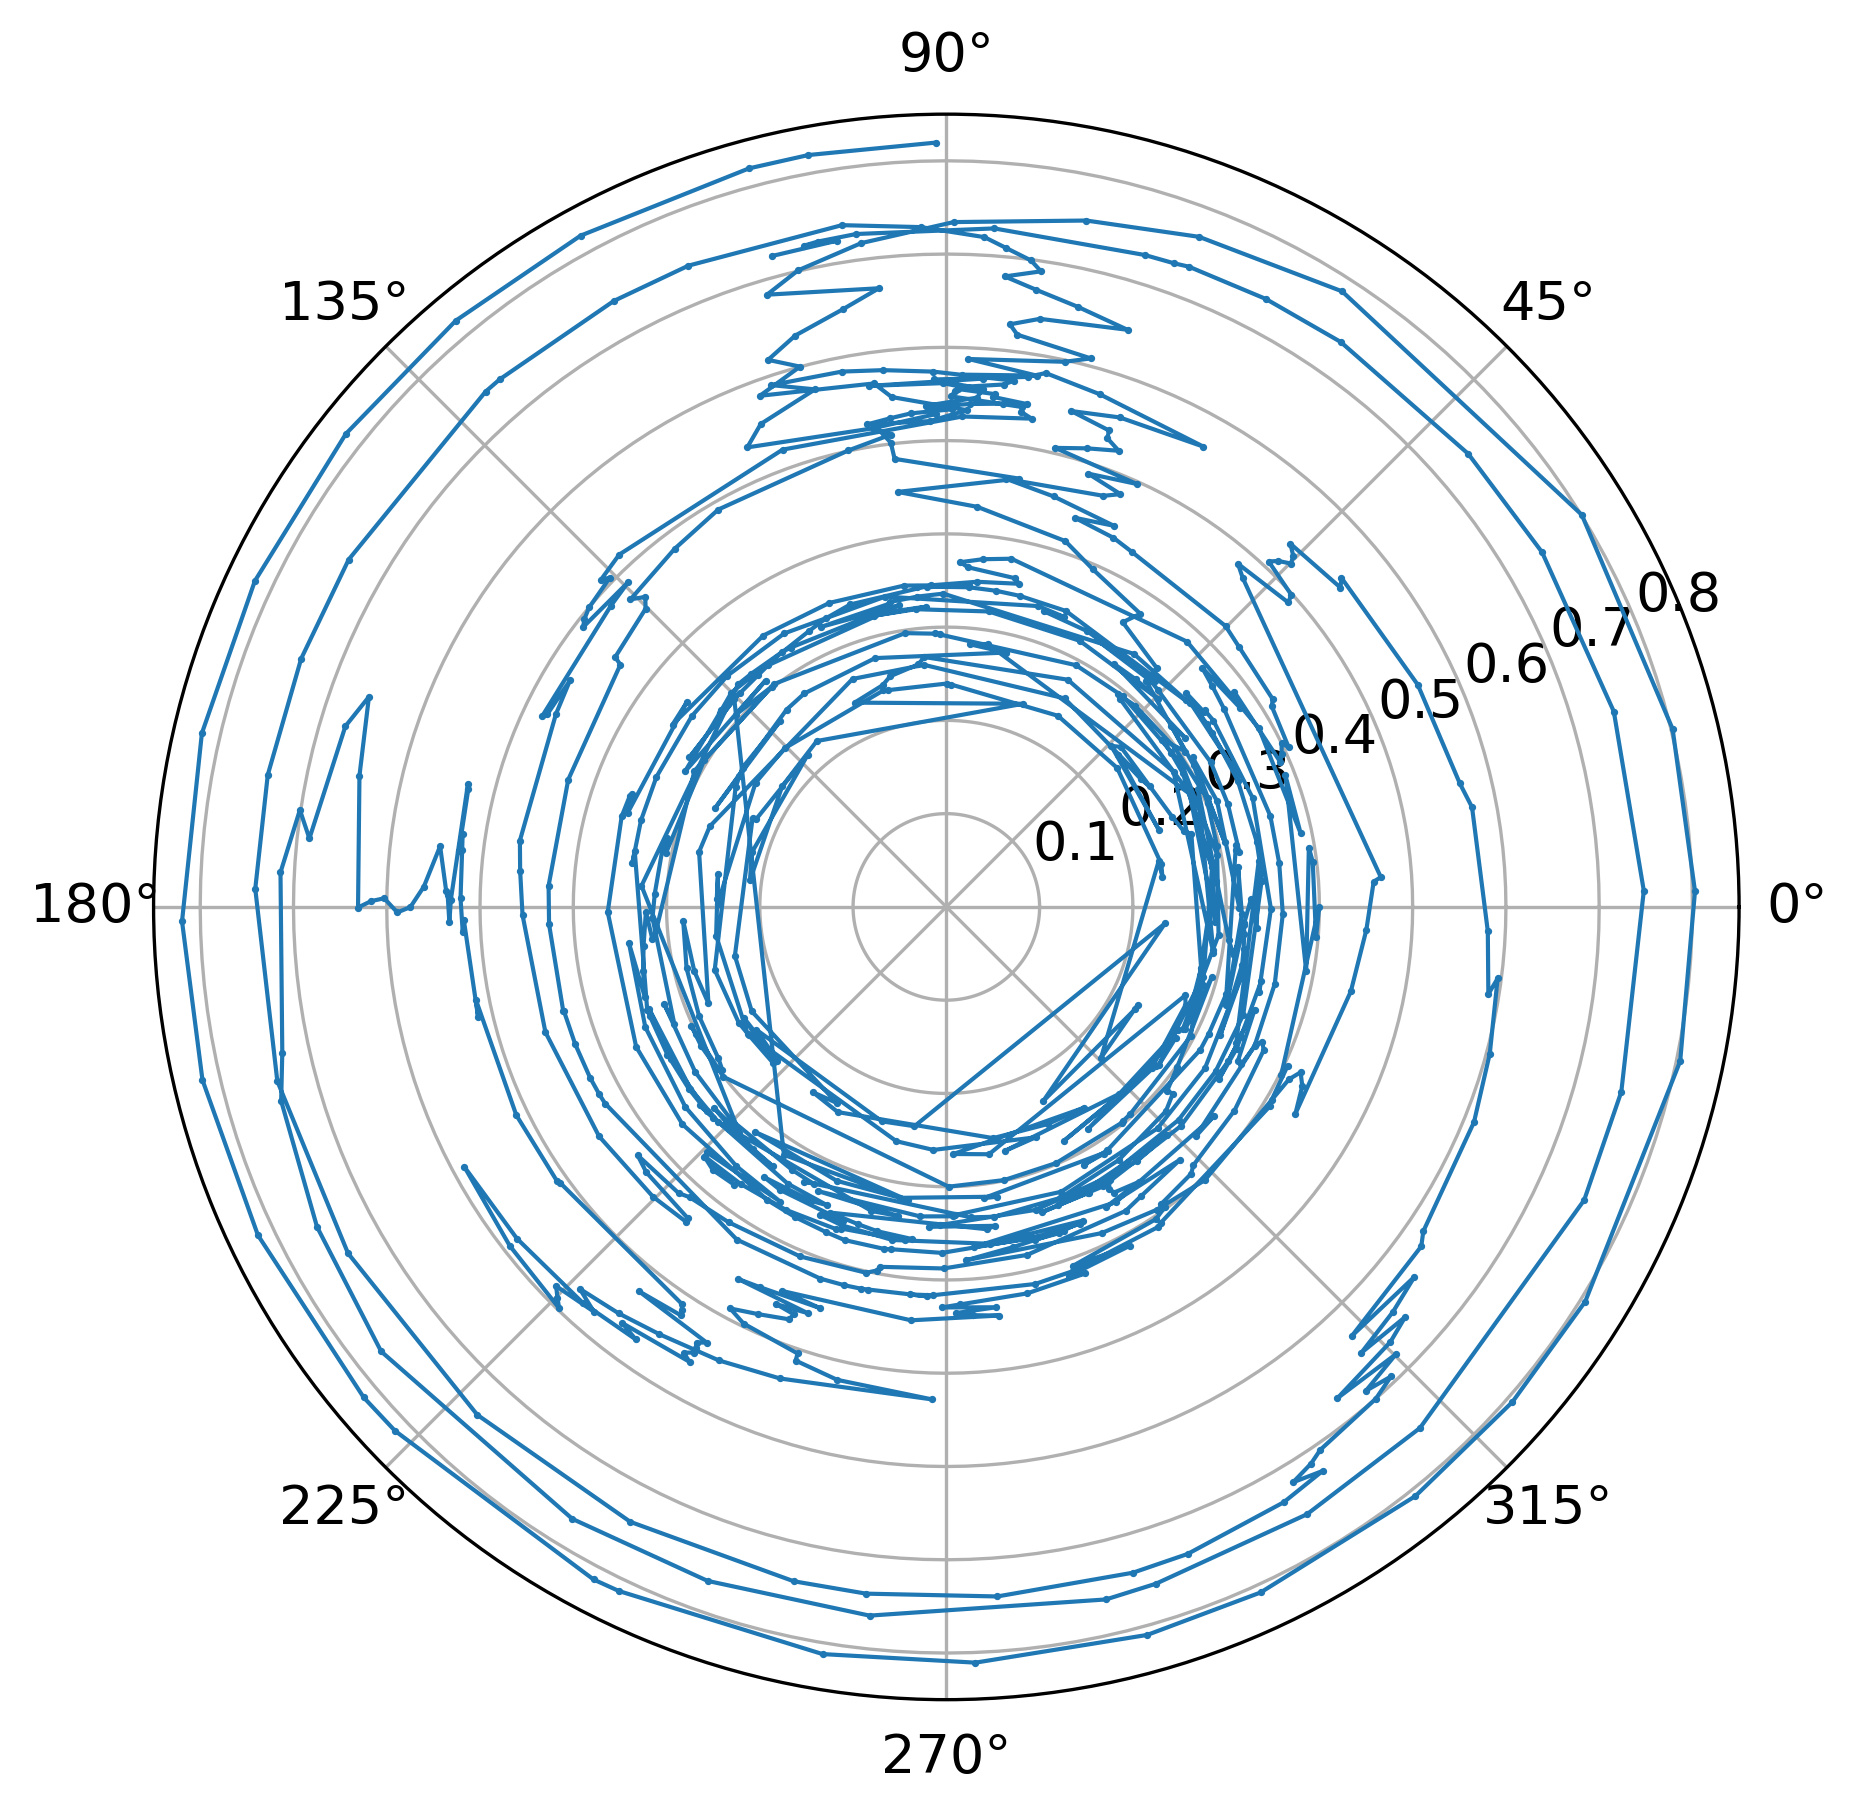

In [27]:
time = np.linspace(
    min(phase_df['time_sec'].min(),rms_delay_df['time_sec'].min()),
    max(phase_df['time_sec'].max(),rms_delay_df['time_sec'].max()),
    10000
)
phase = np.interp(time, phase_df['time_sec'], phase_df['phase_rad'])
sz = np.interp(time, rms_delay_df['time_sec'], rms_delay_df['rms_delay'])
polar_df = pd.DataFrame({'phase_rad':phase, 'rms_delay': sz})
plt.rcParams.update({'font.size': 13,
                     'legend.fontsize':22,
                     'errorbar.capsize': 3,
                     'figure.figsize':(7,7),
                     'figure.dpi':300})
tmax = 5.0 #sec
print(f"shown time = {tmax:.1f} sec")
nmax = int(tmax/max(time)*len(time))
res_plt = polar_df[:nmax]
plt.polar(res_plt['phase_rad'],res_plt['rms_delay'],'.-',
         linewidth=1, markersize=1.5)
plt.show()

In [28]:
# polar_df.to_csv("phase_space_trajectory.csv", index=None)